In [1]:
## example autoencoder for gene expression simulation form gemini using tensor flow KERAS

## see also deep_learning_practice notebook that uses pytorch on MNIST dataset

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition


### generate MNIST dataloaders

In [ ]:
# # download MNIST data from torchvision
# train_dataset = datasets.MNIST(root='data', # file location
#                                    train=True, # If True, creates dataset from ``train-images-idx3-ubyte`` file
#                                    transform=transforms.ToTensor(), #A function/transform that takes in a PIL image and returns a transformed version.
#                                    download=True)

# str(train_dataset)

train data
torch.Size([60000, 28, 28])
test data
torch.Size([10000, 28, 28])
Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([8, 4, 2, 7, 3, 9, 4, 3, 1, 5])
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([2, 1, 5, 6, 1, 3, 5, 1, 9, 2])
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([4, 4, 1, 0, 0, 1, 7, 3, 8, 6])
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([4, 2, 5, 5, 1, 3, 7, 7, 1, 0])
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 7, 5, 7, 7, 7, 2, 4, 3, 9])
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([9, 8, 5, 2, 0, 2, 0, 6, 0, 2])
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([0

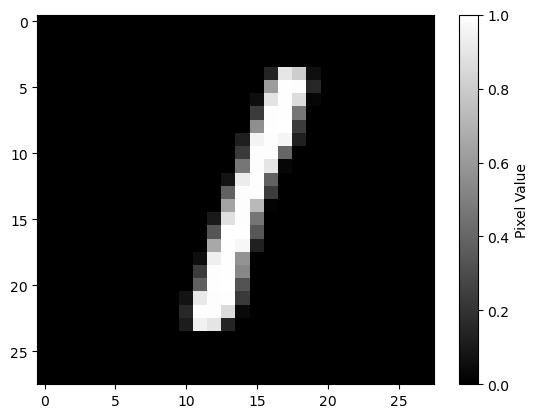

In [9]:
def get_dataloaders_mnist(batch_size, num_workers=0,
                          train_transforms=None, test_transforms=None):
    # if no image transform is specified, transform images into tensors
    if train_transforms is None:
        train_transforms = transforms.ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()
    train_dataset = datasets.MNIST(root='data', # file location
                                   train=True, # If True, creates dataset from ``train-images-idx3-ubyte`` file
                                   transform=train_transforms, #A function/transform that takes in a PIL image and returns a transformed version.
                                   download=False)
    print("train data")
    print(train_dataset.data.shape)
    test_dataset = datasets.MNIST(root='data', 
                                  train=False,
                                  transform=test_transforms,
                                  download=False)
    print("test data")
    print(test_dataset.data.shape)
    # data loader class splits a list of tuples into n mini-batches 
    # each batch is a tuple: tensor 1 data (images), tensor 2 labels
    # note: batches sample without replacment
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
#     valid_dataset = datasets.MNIST(root='data', train=True,
#                                    transform=test_transforms)
#     valid_loader = DataLoader(dataset=valid_dataset,
#                              batch_size=batch_size,
#                              num_workers=num_workers,
#                              shuffle=False)
    return train_loader, test_loader


##### load and split the data
RANDOM_SEED = 49
BATCH_SIZE = 256

train_loader, test_loader = get_dataloaders_mnist(batch_size=BATCH_SIZE, num_workers=2)

# each batch has a tensor containing 256 grayscale images (channels=1), where each image is 28 x 28
print('Training Set:\n')
for images, labels in train_loader: # 235 batches, last batch has only 96 images # seem to be able to automiaticaly iterate through the image/label batches here
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
len(train_loader) 

# look at one image as an example
# Create an iterator
dataiter = iter(train_loader)
first_batch_inputs, first_batch_labels = next(dataiter)
# select first image (1,28,28) and select first chanel (dim). there is only one channel. . . 
numpy_array = first_batch_inputs[0][0].numpy()
plt.imshow(numpy_array, cmap='gray', aspect='auto')
plt.colorbar(label='Pixel Value')

# pixel values all between 0 and 1

In [100]:
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))
        #plt.colorbar(label='Pixel Value')

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

### generate random scRNA data

In [19]:
def generate_synthetic_gene_expression(n_samples, n_genes, n_factors=5, pct_sparse=0):
    """
    Generates synthetic gene expression data.

    Args:
        n_samples: Number of samples (e.g., cells).
        n_genes: Number of genes.
        n_factors: Number of underlying factors influencing gene expression.

    Returns:
        A numpy array of shape (n_samples, n_genes) representing synthetic gene expression data.There are n_factors
        or 'conditions' per sample that influence gene expression. 
    """
    # each set of 'factors' uniquely represents a sample (or condition)
    factors = np.random.rand(n_samples, n_factors) # 5 factors per sample from uniform distr 0-1

    # Simulate gene expression as a linear combination of these factors
    gene_expression = np.random.randn(n_samples, n_genes) * 0.1  # these are small random noise values per matrix cell
    
    for i in range(n_genes):
        # randomly weighted sum of factor values for each sample for this gene
        weights = np.random.rand(n_factors) # (n_factors, )
        gene_expr_i = np.dot(factors, weights)  # (n_samples, n_factors) *dot* (n_factors,) = (n_samples, ))
        # add to noise values the gene expression values across samples 
        gene_expression[:, i] += gene_expr_i
    
    if pct_sparse > 0:
        # RANDOMLY set some expression values per sample to 0
        # sample btw 0-1 uniformly, set true/false if gt pct sparse
        for i in range(n_samples):
            mask = np.random.rand(n_genes) >= pct_sparse  # Create a mask for each sample
            gene_expression[i, :] *= mask 
    
    return gene_expression

# Define parameters
n_samples = 1000
n_genes = 100  # Increased number of genes for demonstration
pct_sparse = 0.2

# Generate synthetic data
gene_expression = generate_synthetic_gene_expression(n_samples, n_genes, pct_sparse=pct_sparse)

# Scale the data to the range [0, 1]
scaler = MinMaxScaler() # won't change the sparsity I dont think
scaled_expression = scaler.fit_transform(gene_expression)

# Split data into training and testing sets
X_train, X_test, _, _ = train_test_split(
    scaled_expression, scaled_expression, test_size=0.2, random_state=42
)

print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

Shape of training data: (800, 100)
Shape of testing data: (200, 100)


{'copy': True, 'iterated_power': 'auto', 'n_components': 3, 'n_oversamples': 10, 'power_iteration_normalizer': 'auto', 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
Eigenvectors
           0         1         2         3         4         5         6   \
PC1  0.106993  0.103394  0.112449  0.099183  0.092359  0.097862  0.095200   
PC2 -0.051331 -0.055551 -0.027041  0.009248  0.004860  0.126758 -0.044983   
PC3 -0.020361  0.035928 -0.136521 -0.014840  0.169396 -0.035364 -0.194530   

           7         8         9   ...        90        91        92  \
PC1  0.102288  0.099454  0.096651  ...  0.100377  0.101601  0.105020   
PC2  0.028066  0.045652 -0.089710  ... -0.085070 -0.021903 -0.015865   
PC3  0.105977 -0.070177 -0.046828  ... -0.086909  0.103926 -0.021168   

           93        94        95        96        97        98        99  
PC1  0.112282  0.082736  0.090601  0.098182  0.106466  0.118334  0.080236  
PC2  0.010943  0.090514  0.212190  0.101475 -

Text(0, 0.5, 'PC3 0.03')

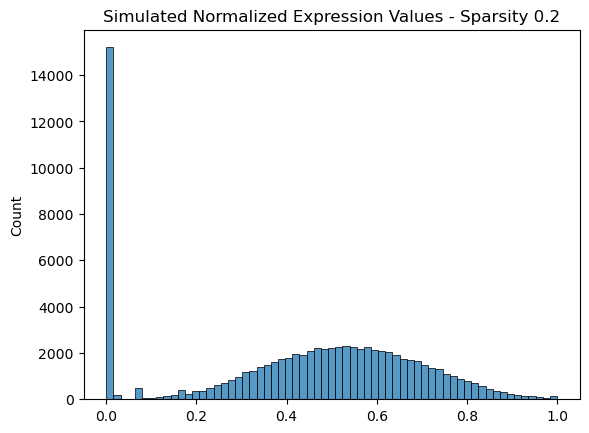

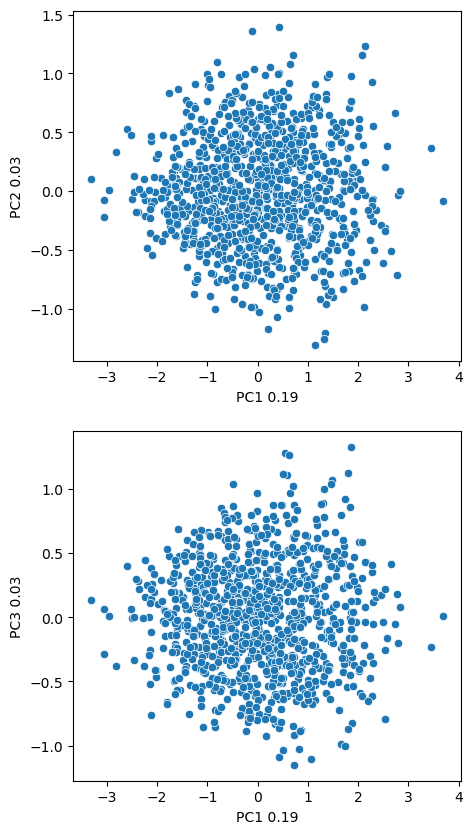

In [20]:
# visualize the expression data with PCA
plt.figure()
sns.histplot(X_train.flatten())
plt.title(f"Simulated Normalized Expression Values - Sparsity {pct_sparse}")

pca = decomposition.PCA(n_components=3) # by default, this centers the values, which is equivalent to decomposing the Covariance matrix
pca.fit(scaled_expression)
print(pca.get_params())
print("Eigenvectors")
df_eigvec = pd.DataFrame(pca.components_)
df_eigvec.index = ["PC1","PC2","PC3"]
print(df_eigvec)
print("Explained variance")
print(pca.explained_variance_ratio_)

# plot data
X_plt = pd.DataFrame(pca.transform(scaled_expression),
                    columns=["PC1","PC2","PC3"]) # each row a sample, each col a component loading
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
sns.scatterplot(data=X_plt, x="PC1", y="PC2", ax=axs[0])
axs[0].set_xlabel(f"PC1 {round(pca.explained_variance_ratio_[0],2)}")
axs[0].set_ylabel(f"PC2 {round(pca.explained_variance_ratio_[1],2)}")
sns.scatterplot(data=X_plt, x="PC1", y="PC3", ax=axs[1])
axs[1].set_xlabel(f"PC1 {round(pca.explained_variance_ratio_[0],2)}")
axs[1].set_ylabel(f"PC3 {round(pca.explained_variance_ratio_[2],2)}")
# each point is a sample

## AE in tensorflow

In [15]:
# using the tf.keras API tf.keras.models.Model()

def build_autoencoder(input_dim, encoding_dim):
    """
    Builds a basic autoencoder model.

    Args:
        input_dim: Dimensionality of the input data (number of genes).
        encoding_dim: Dimensionality of the encoded representation (latent space).

    Returns:
        A tf.keras.Model object representing the autoencoder.
    """
    # Encoder Model ( separate so we can sample from teh feature space later)
    encoder_input = layers.Input(shape=(input_dim,)) #input layer
    encoded = layers.Dense(64, activation='relu')(encoder_input)  # fully connected layer
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded) # fully connected layer
    encoder = models.Model(encoder_input, encoded, name='encoder') # output shape = encoding_dim (n nodes last layer)

    # Decoder Model
    decoder_input = layers.Input(shape=(encoding_dim,)) # input layer
    decoded = layers.Dense(64, activation='relu')(decoder_input)  # fully connected layer
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded) # fully connected layer ** with N_nodes=N_starting input features
    decoder = models.Model(decoder_input, decoded, name='decoder')

    # Autoencoder
    # The models.Model() constructor in Keras needs to know what the input to t
    # the whole model is.  Even though the encoder has its own input layer
    autoencoder_input = layers.Input(shape=(input_dim,))
    encoded_representation = encoder(autoencoder_input)
    decoded_output = decoder(encoded_representation)
    autoencoder = models.Model(autoencoder_input, decoded_output, name='autoencoder')
   
    return autoencoder, encoder, decoder

## Build the autoencoder: n_genes input, n_nodes in 2nd layer
autoencoder, encoder, decoder = build_autoencoder(input_dim=100, encoding_dim=20) # n_genes is set above = 100

# Print model summaries
encoder.summary()
decoder.summary()
autoencoder.summary()

# None dimension here is for flexible batch size

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 7,764
Trainable params: 7,764
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_2 (Dense)             (None, 64) 

In [16]:
# use MSE as a loss function
autoencoder.compile(optimizer='adam', loss='mse') 
# not easy to track correlation between expression inputs and outputs over time b/c keras is not designed
# to do this WITHIN samples ( one corr value per sample) it only does this across all samples, and this might be
# misleading?? so instead plot something like MAE here. Written as a custom class, the corr could me measured. 

In [17]:
# plotting function for tensorflow model training accuracy and loss
def plot_train_res(training_res, train_metric='loss'):
    plt.plot(training_res.history[train_metric])
    #plt.plot(training_res.history[val_metric]) # not available unless you write a custom training loop like in pytorch
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    #plt.legend(['train','test'], loc='upper left')
    return

Epoch 1/150


2025-06-16 12:00:11.323653: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 0s 6ms/step - loss: 0.0731 - val_loss: 0.0729
Epoch 2/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0720
Epoch 3/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0713
Epoch 4/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0706
Epoch 5/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0698
Epoch 6/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0689
Epoch 7/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0680
Epoch 8/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0667
Epoch 9/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0642
Epoch 10/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0610
Epoch 11/150
13/13 [=

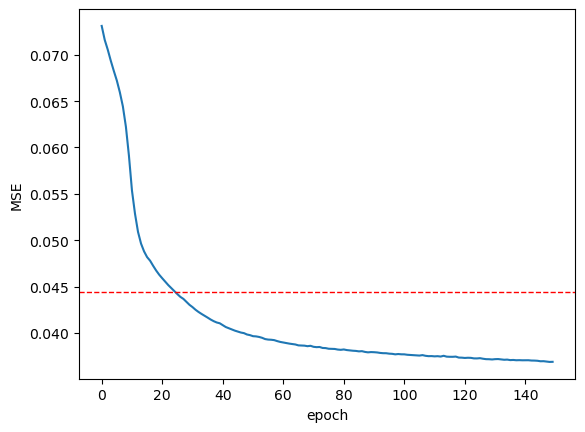

In [21]:
epochs = 150
batch_size = 64

# call the model fit method to train - ** see dropdown docs for tf.keras.Model() for example OOP methods
history = autoencoder.fit(
    x = X_train, # 800 samples by 100 genes in batches of batch_size samples
    y = X_train, # labels/values for the output are the same values as the inputs. tries to reconsturct these.
    epochs=epochs,
    batch_size=batch_size, # input batches of 64 samples (NOT related to input_dim which = 100 genes)
    shuffle=True,  #shuffle train data before each epoch; Has no effect when `steps_per_epoch` is not `None`.
    validation_data=(X_test, X_test), # tell the model to leave out the validation data when generating batches
)

plot_train_res(history)

loss = autoencoder.evaluate(X_test, X_test)
print(f"Test Loss: {loss:.4f}")
plt.axhline(y=loss, color='r', linestyle='--', linewidth=1)

# much harder to reconstruct the test data when train and test are sparse. . . 
# train/test loss (red line) is equal around 30 ep

7/7 [==============================] - 0s 511us/step


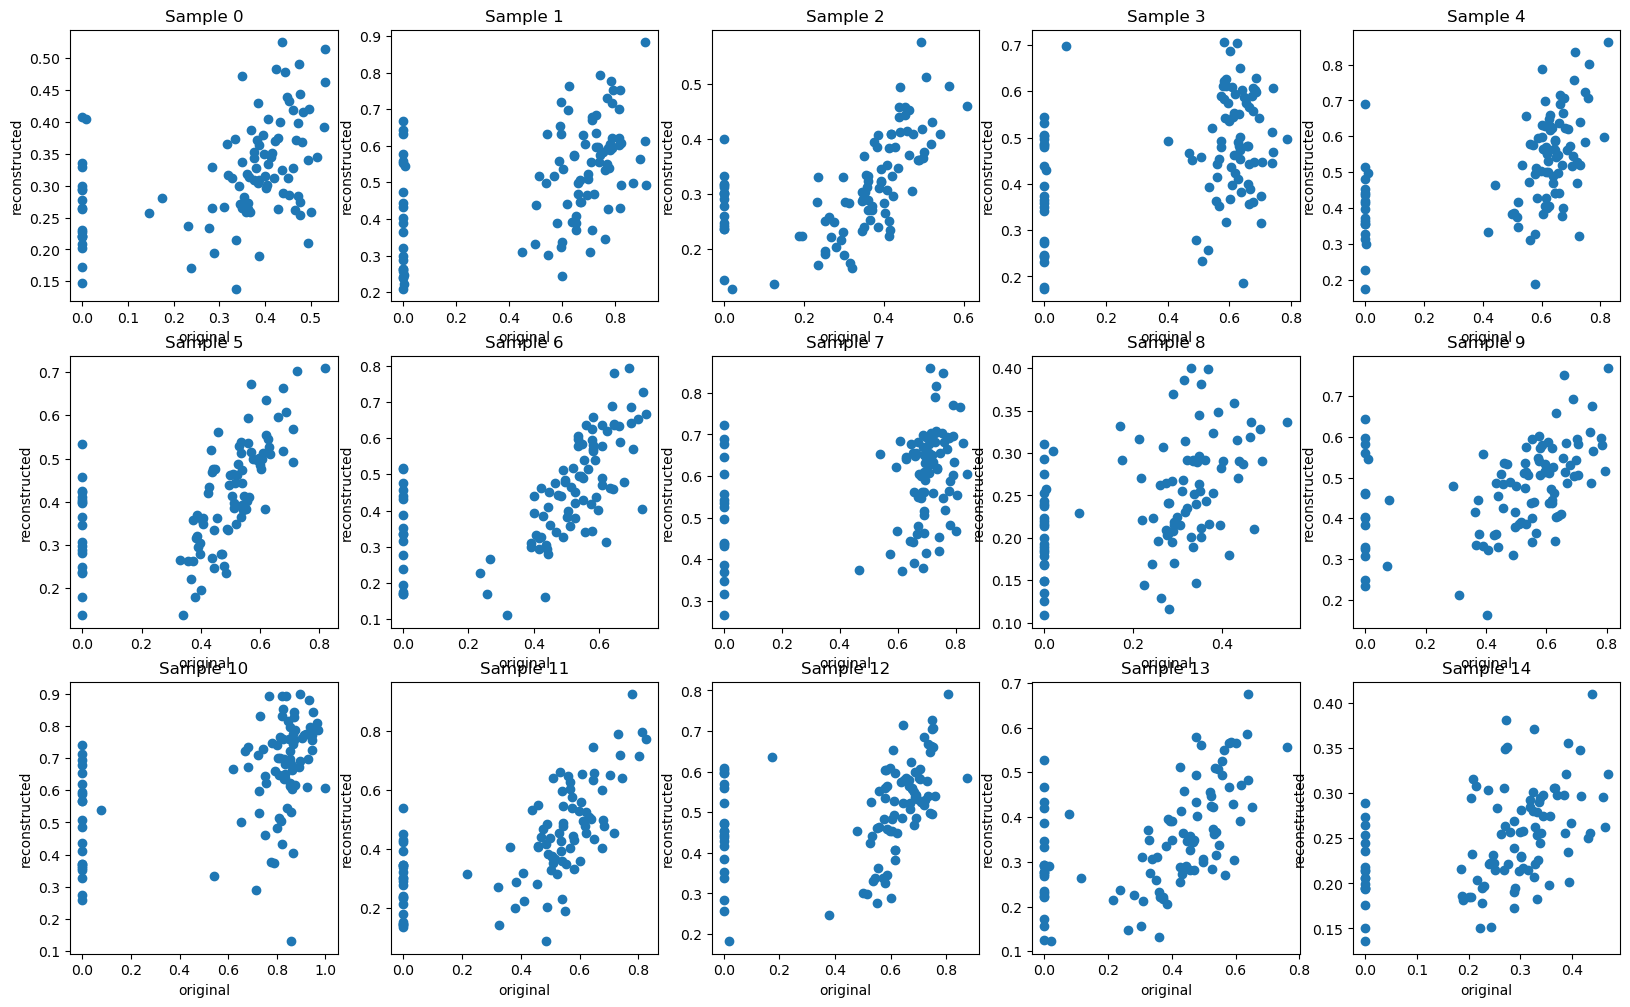

In [22]:
def plot_reconstructed_data(original_data, reconstructed_data, n_samples=5):
    """
    Plots original and reconstructed data for visual comparison.

    Args:
        original_data: The original input data.
        reconstructed_data: The reconstructed output data.
        n_samples: Number of samples to visualize.
    """
    plt.figure(figsize=(20, 12))
    for i in range(n_samples):
        ax = plt.subplot(3, 5, i + 1)
        plt.scatter(x=original_data[i], y=reconstructed_data[i])
        plt.title(f"Sample {i}")
        plt.xlabel("original")
        plt.ylabel("reconstructed")
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
    plt.show()

reconstructed_expression = autoencoder.predict(X_test)

plot_reconstructed_data(original_data = X_test, 
                        reconstructed_data = reconstructed_expression,
                        n_samples=15)

# in sparse data a lot of zero expression values are not reconstructed as zeros . . . 

In [25]:
def generate_synthetic_data_from_latent_space(encoder, decoder, data):
    """
    Generates synthetic data by sampling from the latent space of a trained autoencoder.

    Args:
        encoder: Trained encoder model.
        decoder: Trained decoder model.
        data: The original training data used to train the autoencoder.

    Returns:
        Generated synthetic data.
    """
    ## sample from gaussian distributions based on each latent feature
    # 1. run the original data through the encoder where the output is the N features of the latent space
    encoded_data = encoder.predict(data)

    # 2.  Estimate the mean and standard deviation of the latent space
    latent_means = np.mean(encoded_data, axis=0) # mean value for each feature
    latent_stds = np.std(encoded_data, axis=0) # std for each feature

    # 3. Sample new points from a distribution (e.g., Gaussian) in the latent space
    n_synthetic_samples = 500  # Number of synthetic samples to generate
    random_latent_vectors = np.random.normal(
        latent_means, latent_stds, size=(n_synthetic_samples, encoded_data.shape[1]) # matrix n_samples x n_latent_features
    ) # each element in the resulting array will be drawn from a normal distribution with the corresponding mean and standard deviation.
    print(random_latent_vectors.shape) # 500 x 20
    
    # Translate the sampled features into simulated samples with orig num features using decoder layer
    synthetic_data = decoder.predict(random_latent_vectors)
    return synthetic_data

# Generate synthetic data
synthetic_expression_from_latent = generate_synthetic_data_from_latent_space(encoder, decoder, X_train)

print("Shape of synthetic expression data:", synthetic_expression_from_latent.shape)


25/25 [==============================] - 0s 483us/step
(500, 20)
16/16 [==============================] - 0s 335us/step
Shape of synthetic expression data: (500, 100)


(500, 3)


Text(0, 0.5, 'PC3 0.026')

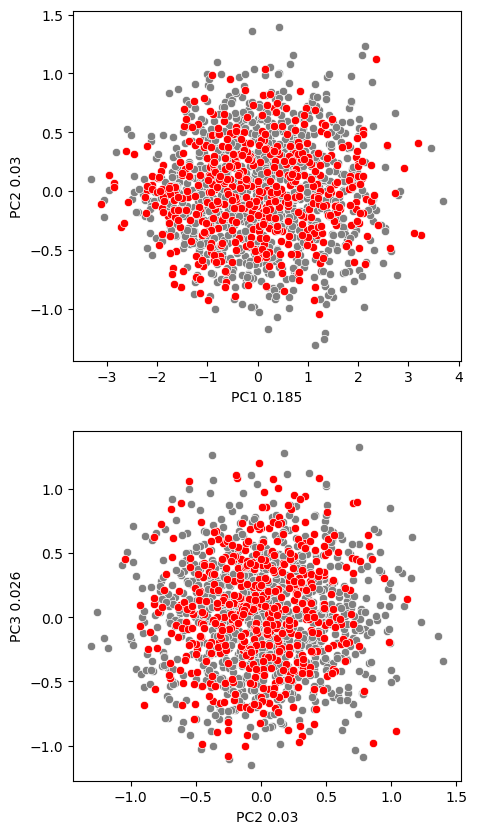

In [26]:
# plot simulated data on the original PCA axes
X_sim = pca.transform(synthetic_expression_from_latent)
print(X_sim.shape)
# use pca previously triained on the entire scaled expression data set
X_sim = pd.DataFrame(X_sim,
                    columns=["PC1","PC2","PC3"]) # each row a sample, each col a component loading
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
sns.scatterplot(data=X_plt, x="PC1", y="PC2", ax=axs[0], color='grey') # original samples
sns.scatterplot(data=X_sim, x="PC1", y="PC2", ax=axs[0], color='red') # simulated samples
axs[0].set_xlabel(f"PC1 {round(pca.explained_variance_ratio_[0],3)}")
axs[0].set_ylabel(f"PC2 {round(pca.explained_variance_ratio_[1],3)}")

sns.scatterplot(data=X_plt, x="PC2", y="PC3", ax=axs[1], color='grey') # original samples
sns.scatterplot(data=X_sim, x="PC2", y="PC3", ax=axs[1], color='red') # simulated samples
axs[1].set_xlabel(f"PC2 {round(pca.explained_variance_ratio_[1],3)}")
axs[1].set_ylabel(f"PC3 {round(pca.explained_variance_ratio_[2],3)}")

# pretty good for non-sparse data!
# on reduced pca dimensions, also pretty good for sparse data

## AutoEncoder in pytorch

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

import matplotlib.colors as mcolors

In [46]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Set the number of hidden units in the bottle neck
        self.num_hidden = 8
        # Define the encoder model
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # input size one sample/image: 784=28x28 linearized pixel grid, output size: 256 features per image (not related to batch size)
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, self.num_hidden),  # input size: 256 features/image, output size: num_hidden=n_nodes per image
            nn.ReLU(),  # apply the ReLU activation function
        )
        
        # Define the decoder model
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # input size: 8 features/nodes, output size: 256 features per image
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, 784),  # input size: 256 features per image, output size: 784 reconstructed pixels per image 
            nn.Sigmoid(),  # apply the sigmoid activation function elementwise to compress each pixel to a range (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder model
        encoded = self.encoder(x)
        # Pass the encoded output through the decoder model
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded

train data
torch.Size([60000, 28, 28])
test data
torch.Size([10000, 28, 28])


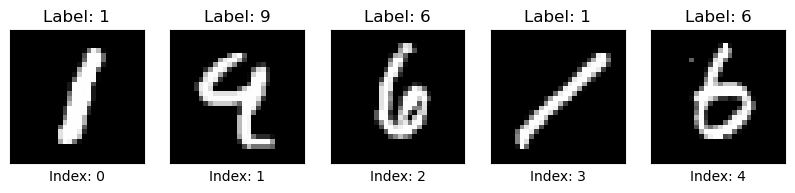

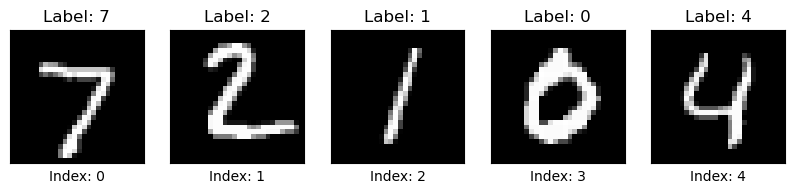

In [76]:
# generate data loaders for teh MNIST data and check
BATCH_SIZE = 256
train_loader, test_loader = get_dataloaders_mnist(batch_size=BATCH_SIZE, num_workers=2)

for images, labels in train_loader: # this is an iterator
    numpy_array = images[0:5,...] # 256x1x28x28
    labels=labels[0:5] #256x1
    #plt.imshow(numpy_array, cmap='gray', aspect='auto')
    #plt.colorbar(label='Pixel Value')
    show_images(images=numpy_array, labels=labels)
    break

for images, labels in test_loader: # this is an iterator
    numpy_array = images[0:5,...] # 256x1x28x28
    labels=labels[0:5] #256x1
    #plt.imshow(numpy_array, cmap='gray', aspect='auto')
    #plt.colorbar(label='Pixel Value')
    show_images(images=numpy_array, labels=labels)
    break

In [92]:
def train_ae(train_loader, test_loader, learning_rate=1e-3, num_epochs=10, batch_size=BATCH_SIZE):
    # Convert the training data to PyTorch tensors
    # X_train = torch.from_numpy(X_train).to(device)
    # Create the autoencoder model and optimizer
    model = AutoEncoder()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Define the loss function
    criterion = nn.MSELoss() # output a vector of loss terms, one per sample
    # Training loop
    train_res = {'train_loss':[],
                 'test_loss':[]}
    for epoch in range(num_epochs):
        running_loss = 0.0 # reset running loss at start of epoch
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Get a batch of training data, minus labels, and move it to the device
            images_flat = images.reshape(images.size(0), -1) # 256 images, each flattened to 1 dimention
            images_flat = images_flat.to("cpu")
            # Forward pass
            encoded, decoded = model(images_flat)
            # Compute the loss and perform backpropagation
            loss = criterion(decoded, images_flat)
            optimizer.zero_grad() # reset gradients of all model params for this minibatch
            loss.backward() # calculate the new gradients for the updated params
            optimizer.step() # one step to change model params according to gradients and learning rate.
            # Convert the minibatch loss internal tensor to a vector and 
            running_loss += loss.item() * images.size(0) # convert average image loss to a scalar and mult by num_images_in_batch; add to running epoch loss
        # Print the epoch loss = total loss for this epoch div by num of batches processed in the in the epoch
        epoch_loss = running_loss / len(train_loader) #avg per batch epoch loss
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))
        
        # Testing Phase
        model.eval() # Set the model to evaluation mode
        running_test_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation during testing
            for images_t, labels_t in test_loader:
                images_t_flat = images_t.reshape(images_t.size(0), -1)
                test_encoded, test_decoded = model(images_t_flat)
                loss = criterion(test_decoded, images_t_flat)
                running_test_loss += loss.item() * images_t.size(0) # one value per test batch
                # print(f"input mean first few images: {torch.mean(images_t_flat[0:8,...], dim=1)}")
                # print(f"output mean first few images: {torch.mean(test_decoded[0:8, ...], dim=1)}")
                # print(f"Max diff between input and decoded: {(test_decoded - images_t_flat).abs().max().item()}")
        epoch_test_loss = running_test_loss / len(test_loader.dataset) #avg for epoch
        
        train_res['train_loss'].append(epoch_loss)
        train_res['test_loss'].append(epoch_test_loss)     
    # Return the trained model
    return model, train_res

In [93]:
ae_model, ae_train_res = train_ae(train_loader, test_loader)

Epoch 1/10: loss=16.6337
Epoch 2/10: loss=11.6892
Epoch 3/10: loss=9.9600
Epoch 4/10: loss=9.4649
Epoch 5/10: loss=9.1825
Epoch 6/10: loss=8.9706
Epoch 7/10: loss=8.8075
Epoch 8/10: loss=8.6734
Epoch 9/10: loss=8.5626
Epoch 10/10: loss=8.4736


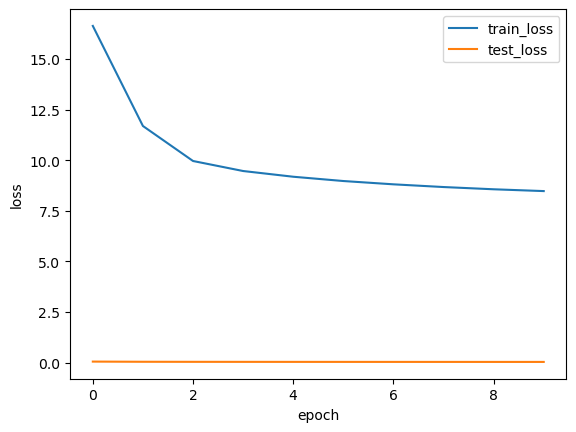

In [94]:
# plot torch model loss
def plot_train_res(training_res, train_metrics=['loss']):
    plt.figure()
    for m in train_metrics:
        plt.plot(training_res[m], label=m)
    #plt.plot(training_res.history[val_metric]) # not available unless you write a custom training loop like in pytorch
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    return

plot_train_res(ae_train_res, train_metrics=['train_loss','test_loss'])

# checked that input and output are not the same
# consistently low train loss and test loss might indicate an identity model . . .but double check encoder outputs to besure
# low train loss, high test loss would indicate overfitting . . 
# this seems a very accurate model:

In [ ]:
# visualize some samples from teh latent space . . these would not be specific to each class tho. . . .

## VAE in pytorch
cite: https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

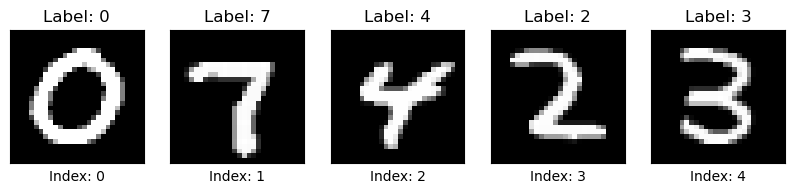

In [101]:
# generate data loaders for the MNIST data and check

train_loader, test_loader = get_dataloaders_mnist(batch_size=256, num_workers=2)

for images, labels in train_loader: 
    numpy_array = images[0:5,...] # 256x1x28x28
    labels=labels[0:5] #256x1
    show_images(images=numpy_array, labels=labels)
    break

VAEs have a prior (distribution, p(z)) assumed for the values of each each latent feature (which is usually set to a standard normal distribution).  The true posterior distribution p(z∣x) represents the probability distribution over the latent variables z given a specific observed data point(s) x. This is the ideal distribution that we want our encoder to learn. 

Since the true posterior p(z∣x) is intractable, VAEs introduce an approximate posterior distribution, denoted as qϕ(z∣x). This is the distribution that your encoder network learns to output.

One VAE loss function (the **ELBO - Evidence Lower Bound**) explicitly involves these distributions:

Minimizing this term encourages the encoder to map inputs into latent distributions that generally resemble the simple prior.

![ELBO_loss](./ELBO_loss.png)

In [125]:
class VAE(AutoEncoder): # inherits from class created above
    def __init__(self):
        super().__init__()
        # a feature layer that will LEARN the mean of each sampled feature in next layer
        self.mu = nn.Linear(self.num_hidden, self.num_hidden) 
        # a feature layer that will LEARN the log variance of each feature sampled in next layer
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden) 

    def reparameterize(self, mu, log_var):
        # Compute the standard deviations from the log variances
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std) # generate tensor with one noise term per feature n=len(std), each drawn from a standard gaussian with mean 0 var 1
        # Return the reparameterized samples - each sample feature effectively sampled from a gausian with learned mean and log_var terms in prev layer
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable - this step is deterministic and thus differentiable (not like random sampling itself)
        z = self.reparameterize(mu, log_var) # generates n=len(mu) new gausian features for each sample in batch, acting like a layer
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        # a function for generating new samples from the model after training
        with torch.no_grad():
            # Generate random feature values from a Standard Normal Dist. 
            z = torch.randn(num_samples, self.num_hidden).to("cpu") # generate new latent sample features for n_samples
            # translate the latent features using the decoder and return the synthetic sample data. 
            # the decoder has been trained to take ANY standard normally distrib feature values and translate them back into output data. 
            samples = self.decoder(z)
        # Return the generated samples
        return samples

In [126]:
# Define a loss function that combines binary cross-entropy and Kullback-Leibler divergence - example not run
def loss_function(recon_x, x, mu, logvar):
    # Compute the binary cross-entropy loss between the reconstructed output and the input data
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a STANDARD Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # torch sums all the element-wise vector outputs to get a single scalar for the batch
    # Combine the two losses by adding them together and return the result
    return BCE + KLD # might need to rebalance/weight these terms

In [127]:
def train_vae(train_loader, test_loader, learning_rate=1e-3, num_epochs=10, batch_size=32):
    model = VAE()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_res = {'train_loss':[],
                 'test_loss':[]}
    # Define the loss function
    criterion = nn.MSELoss(reduction="sum")
    # Set the device to GPU if available, otherwise use CPU
    model.to("cpu")
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (images, _) in enumerate(train_loader):
            images_flat = images.reshape(images.size(0), -1) # 256 images, each flattened to 1 dimention
            images_flat = images_flat.to("cpu")
            # Forward pass
            encoded, decoded, mu, log_var = model(images_flat)
            # Compute the loss and perform backpropagation
            # combined loss is standard reconstruction MSE plus KLD of the learned feature distributions
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # This term acts as a regularizer, encouraging the latent space to be well-structured and continuous, which is crucial for the VAE's generative capabilities.
            loss = criterion(decoded, images_flat) + 3 * KLD
            # or use above loss function?
            #loss = loss_function(decoded, images_flat, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update the running loss
            total_loss += loss.item() * images.size(0) # avg sample loss * num samples

        # Print the epoch loss - total loss summed across batchs, idv by num batches
        epoch_loss = total_loss / len(train_loader.dataset)
        print("Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))
        
        # Testing Phase
        model.eval() # Set the model to evaluation mode
        running_test_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation during testing
            for images_t, labels_t in test_loader:
                images_t_flat = images_t.reshape(images_t.size(0), -1)
                test_encoded, test_decoded, mu_t, log_var_t = model(images_t_flat)
                # test loss
                # latent feature log_vars and mus from each node output activation is a weighted combination of the input test or train features, output diff for each batch
                # the weights that generate the feature mus and vars are learned during training
                KLD = -0.5 * torch.sum(1 + log_var_t - mu_t.pow(2) - log_var_t.exp()) 
                loss = criterion(test_decoded, images_t_flat) + 3 * KLD
                running_test_loss += loss.item() * images_t.size(0) # one loss value added per test batch
                # print(f"input mean first few images: {torch.mean(images_t_flat[0:8,...], dim=1)}")
                # print(f"output mean first few images: {torch.mean(test_decoded[0:8, ...], dim=1)}")
                # print(f"Max diff between input and decoded: {(test_decoded - images_t_flat).abs().max().item()}")
        epoch_test_loss = running_test_loss / len(test_loader.dataset) #avg for epoch
        train_res['train_loss'].append(epoch_loss)
        train_res['test_loss'].append(epoch_test_loss)     

    return model, train_res

In [108]:
BATCH_SIZE = 256
train_loader, test_loader = get_dataloaders_mnist(batch_size=BATCH_SIZE, num_workers=2)

train data
torch.Size([60000, 28, 28])
test data
torch.Size([10000, 28, 28])


In [128]:
vae, train_res = train_vae(train_loader, test_loader)

Epoch 1/10: loss=15536.7178
Epoch 2/10: loss=13467.1338
Epoch 3/10: loss=13313.0844
Epoch 4/10: loss=13219.9123
Epoch 5/10: loss=13113.7973
Epoch 6/10: loss=13004.6027
Epoch 7/10: loss=12925.3164
Epoch 8/10: loss=12878.1485
Epoch 9/10: loss=12848.1250
Epoch 10/10: loss=12817.0311


Original Images


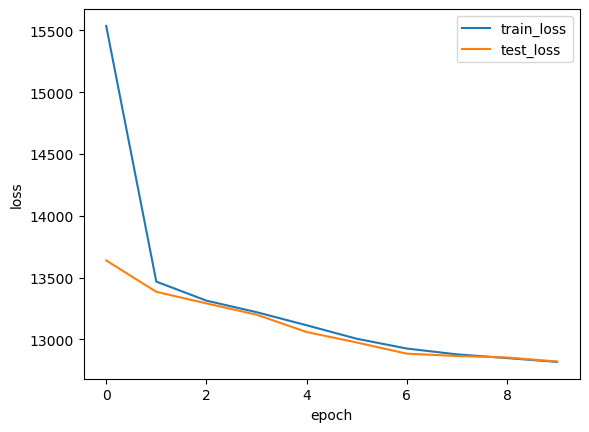

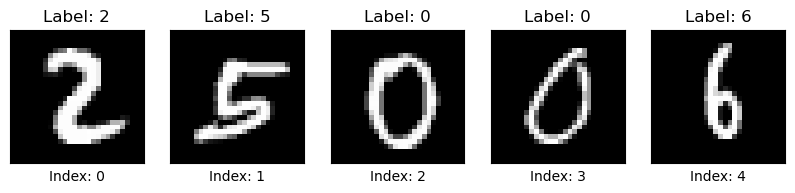

Renconstructed Images


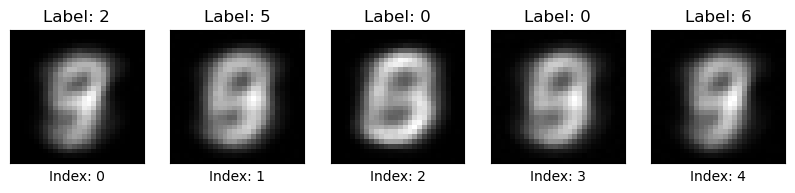

Synthetic Images


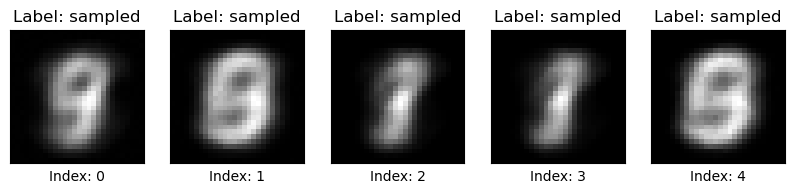

In [129]:
# plot training loss
plot_train_res(train_res, ["train_loss","test_loss"]) # Ta Da!

# show some reconstructed data
vae.eval()
vae.to("cpu")
# Get one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images[0:5]
labels = labels[0:5]

with torch.no_grad(): # Disable gradient calculation for inference
    images_flat = images.reshape(images.size(0), -1)
    images_flat = images_flat.to("cpu") # Move images to the same device as the model
    _, reconstructed_images, _, _ = vae(images_flat)
    # The forward method returns (encoded, decoded, mu, log_var)

# Move tensors to CPU and convert to numpy for plotting
print("Original Images")
original_images_np = images.cpu().numpy()
show_images(images=original_images_np, labels=labels)

print("Renconstructed Images")
reconstructed_images = reconstructed_images.reshape(reconstructed_images.shape[0], 1, 28, 28)
reconstructed_images_np = reconstructed_images.cpu().numpy()
show_images(images=reconstructed_images_np, labels=labels)

print("Synthetic Images")
syn_images = vae.sample(5)
syn_images = syn_images.reshape(syn_images.shape[0], 1, 28, 28)
syn_images_np = syn_images.cpu().numpy()
show_images(images=syn_images_np, labels=np.repeat("sampled",5))


## CVAE in pytorch
cite: https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f

In [ ]:
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

import matplotlib.colors as mcolors

In [131]:
class ConditionalVAE(VAE): #inhertits from two classes above
    def __init__(self, num_classes):
        super().__init__()
        # inherits self.mu and self.log_var
        # Add a linear layer for the class label
        # transform the one-hot class label into a dense vector representation that is compatible with latent space dimension
        # Each output feature of this layer is a learned, weighted sum of the input one-hot vector, followed by the ReLU.
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, self.num_hidden),
            nn.ReLU(),
        )
        # A non-linear activation function. It adds non-linearity to the label projection, 
        #allowing the model to learn more complex relationships between the class label and the latent space. 

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(y.float())
        # equivalent to implementing nn.Sequential(**arg).forward(y.float) - takes the 10d-one-hot label y and outputs num_hidden features
        # Adding the Projected label features essentially "shifts" or "biases" the latent vector z 
        # in a direction that corresponds to the desired class.
        return z + projected_label

    def forward(self, x, y):
        encoded = self.encoder(x)
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variables that are adjusted using label inputs through the decoder
        decoded = self.decoder(self.condition_on_label(z, y))
        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random feature values from std normal distrib
            z = torch.randn(num_samples, self.num_hidden).to("cpu")
            # pass the desired onehot label vector throught the label projection 'layer' and then add the learned label projection features 
            # to the randomly sampled features. This is conditioning the random data 'prior' on the desired label
            # Pass the conditioned features through the decoder to generate samples
            samples = self.decoder(self.condition_on_label(z, y))
        return samples

In [138]:
def train_cvae(train_loader, test_loader, num_classes=10, learning_rate=1e-3, num_epochs=10, batch_size=32):
    model = ConditionalVAE(num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_res = {'train_loss':[],
                 'test_loss':[]}
    # Define the reconstruction loss function
    criterion = nn.MSELoss(reduction="sum")
    # Set the device to GPU if available, otherwise use CPU
    model.to("cpu")
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images_flat = images.reshape(images.size(0), -1) # 256 images, each flattened to 1 dimention
            images_flat = images_flat.to("cpu")
            labels_onehot = F.one_hot(labels, num_classes)
            # Forward pass
            encoded, decoded, mu, log_var = model(images_flat, labels_onehot)
            # Compute the divergence (KL divergence compares latent feature distrb to a normal distribution) and perform backpropagation
            # # This term acts as a regularizer, encouraging the latent space to be well-structured and continuous
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
            loss = criterion(decoded, images_flat) + 3 * KLD
            #loss = loss_function(decoded, images_flat, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update the running loss
            total_loss += loss.item() * images.size(0) # avg sample loss * num samples

        # Print the epoch loss - total loss summed across batchs, idv by num batches
        epoch_loss = total_loss / len(train_loader.dataset)
        print("Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))
        
        # Testing Phase
        model.eval() # Set the model to evaluation mode
        running_test_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation during testing
            for images_t, labels_t in test_loader:
                images_t_flat = images_t.reshape(images_t.size(0), -1)
                labels_t_onehot = F.one_hot(labels_t, num_classes)
                test_encoded, test_decoded, mu_t, log_var_t = model(images_t_flat, labels_t_onehot)
                # test loss
                # KLD is different for each test batch: latent feature log_vars and mus from each node output activation is a weighted combination of the input test features, 
                # but the weights that generate the feature mus and vars are learned during training
                KLD = -0.5 * torch.sum(1 + log_var_t - mu_t.pow(2) - log_var_t.exp()) 
                loss = criterion(test_decoded, images_t_flat) + 3 * KLD
                running_test_loss += loss.item() * images_t.size(0) # one loss value added per test batch
                # print(f"input mean first few images: {torch.mean(images_t_flat[0:8,...], dim=1)}")
                # print(f"output mean first few images: {torch.mean(test_decoded[0:8, ...], dim=1)}")
                # print(f"Max diff between input and decoded: {(test_decoded - images_t_flat).abs().max().item()}")
        epoch_test_loss = running_test_loss / len(test_loader.dataset) #avg for epoch
        train_res['train_loss'].append(epoch_loss)
        train_res['test_loss'].append(epoch_test_loss)     

    return model, train_res

In [139]:
cvae, train_res = train_cvae(train_loader, test_loader, num_classes=10)

Epoch 1/10: loss=15124.0828
Epoch 2/10: loss=12436.5960
Epoch 3/10: loss=11707.5977
Epoch 4/10: loss=11270.3328
Epoch 5/10: loss=10974.5221
Epoch 6/10: loss=10750.1609
Epoch 7/10: loss=10546.4245
Epoch 8/10: loss=10383.1479
Epoch 9/10: loss=10247.6028
Epoch 10/10: loss=10145.2124


Original Images


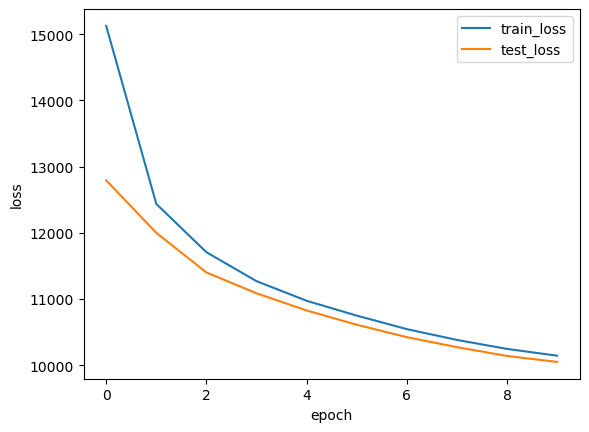

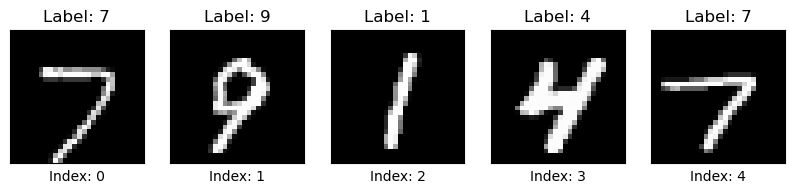

Renconstructed Images


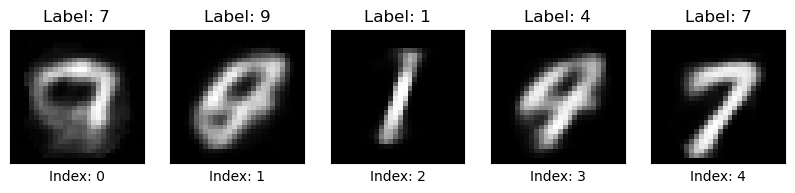

Synthetic Images


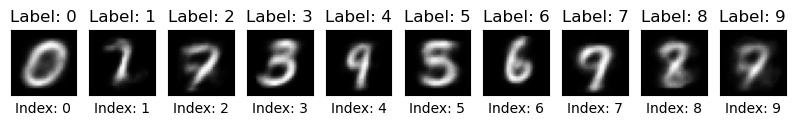

In [143]:
# plot training loss
plot_train_res(train_res, ["train_loss","test_loss"]) # Ta Da!

# show some reconstructed data
cvae.eval()
cvae.to("cpu")
# Get one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images[0:5]
labels = labels[0:5]

with torch.no_grad(): # Disable gradient calculation for inference
    images_flat = images.reshape(images.size(0), -1)
    images_flat = images_flat.to("cpu") # Move images to the same device as the model
    labels_onehot = F.one_hot(labels, num_classes=10)
    _, reconstructed_images, _, _ = cvae(images_flat, labels_onehot)
    # The forward method returns (encoded, decoded, mu, log_var)

# Move tensors to CPU and convert to numpy for plotting
print("Original Images")
original_images_np = images.cpu().numpy()
show_images(images=original_images_np, labels=labels)

print("Renconstructed Images")
reconstructed_images = reconstructed_images.reshape(reconstructed_images.shape[0], 1, 28, 28)
reconstructed_images_np = reconstructed_images.cpu().numpy()
show_images(images=reconstructed_images_np, labels=labels)

print("Synthetic Images")
wanted_image_labels = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]))
syn_images = cvae.sample(num_samples=10, y=wanted_image_labels)
syn_images = syn_images.reshape(syn_images.shape[0], 1, 28, 28)
syn_images_np = syn_images.cpu().numpy()
show_images(images=syn_images_np, labels=[0,1,2,3,4,5,6,7,8,9])


Epoch 1/50: loss=15264.6081
Epoch 2/50: loss=12334.0204
Epoch 3/50: loss=11462.1659
Epoch 4/50: loss=10978.2809
Epoch 5/50: loss=10679.6650
Epoch 6/50: loss=10482.5009
Epoch 7/50: loss=10307.2584
Epoch 8/50: loss=10185.6592
Epoch 9/50: loss=10087.4190
Epoch 10/50: loss=10000.2291
Epoch 11/50: loss=9925.3393
Epoch 12/50: loss=9858.0789
Epoch 13/50: loss=9798.9487
Epoch 14/50: loss=9747.1259
Epoch 15/50: loss=9705.5183
Epoch 16/50: loss=9661.8986
Epoch 17/50: loss=9629.0529
Epoch 18/50: loss=9583.5560
Epoch 19/50: loss=9555.1840
Epoch 20/50: loss=9543.7791
Epoch 21/50: loss=9518.9892
Epoch 22/50: loss=9490.1945
Epoch 23/50: loss=9473.6514
Epoch 24/50: loss=9459.8660
Epoch 25/50: loss=9440.3254
Epoch 26/50: loss=9423.5596
Epoch 27/50: loss=9410.2115
Epoch 28/50: loss=9388.4648
Epoch 29/50: loss=9381.5653
Epoch 30/50: loss=9377.2009
Epoch 31/50: loss=9353.3585
Epoch 32/50: loss=9341.8915
Epoch 33/50: loss=9338.4716
Epoch 34/50: loss=9334.2353
Epoch 35/50: loss=9317.4603
Epoch 36/50: loss=9

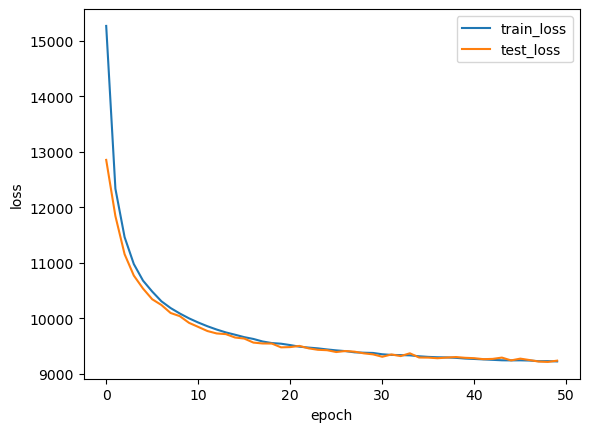

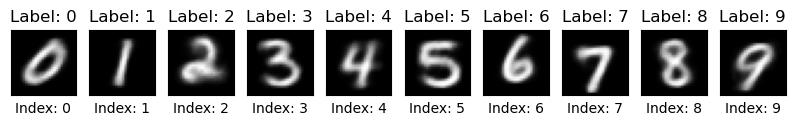

In [144]:
# reconstruction and sampling are not very good . . .similar digits are being mixed together (3=8, 1=7, 4=9)
# train the model longer . . .
# if all digits looked similar, it could be that the KL loss is overshadowing the reconstruction MSE loss.
cvae2, train_res2 = train_cvae(train_loader, test_loader, num_classes=10, num_epochs=50)

# plot training loss
plot_train_res(train_res2, ["train_loss","test_loss"]) 

print("Synthetic Images")
wanted_image_labels = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]))
syn_images = cvae2.sample(num_samples=10, y=wanted_image_labels)
syn_images = syn_images.reshape(syn_images.shape[0], 1, 28, 28)
syn_images_np = syn_images.cpu().numpy()
show_images(images=syn_images_np, labels=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
## better!!!